In [200]:
# General Imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit Imports
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.primitives import Estimator
from qiskit.opflow import TwoQubitReduction
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

# Qiskit Nature Imports
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD
from qiskit_nature.second_q.mappers import QubitConverter
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver

In [210]:
def get_driver(dist):
    # Define driver for BeH2 Molecule
    driver = PySCFDriver(
        atom=f"Be 0 0 0; H -{dist} 0 0; H {dist} 0 0",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    return driver

def transform(problem):
    # specify active space transformation
    active_space_trafo = ActiveSpaceTransformer(
        num_electrons=problem.num_particles, 
        num_spatial_orbitals=3
    )
    # transform the electronic structure problem
    problem = active_space_trafo.transform(problem)
    return problem

def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolver()
    groundstate_solver = GroundStateEigensolver(converter, solver)
    result = groundstate_solver.solve(problem)
    return result

def get_ansatz():
    ansatz = EfficientSU2(
        num_qubits = 4, 
        reps = 1, 
        entanglement = "linear", 
        insert_barriers=True
    )
    return ansatz

def vqe_solver(problem, converter):
    solver = VQE(
        estimator = Estimator(), 
        ansatz = get_ansatz(), 
        optimizer = SPSA(maxiter = 1500)
    )
    groundstate_solver = GroundStateEigensolver(converter, solver)
    result = groundstate_solver.solve(problem)
    return result

In [218]:
distances = np.arange(0.3, 4.0, 0.1)
exact_energies = []
vqe_energies = []

In [219]:
for dist in distances:

    # Define driver for BeH2 Molecule
    driver = PySCFDriver(
        atom=f"Be 0 0 0; H -{dist} 0 0; H {dist} 0 0",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    problem = get_driver(dist).run()

    problem = transform(problem)

    converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)

    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)

    vqe_result = vqe_solver(problem, converter)
    vqe_energies.append(vqe_result.total_energies[0].real)

    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_energies[-1]:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

Interatomic Distance: 0.3 VQE Result: -10.32979 Exact Energy: -10.33001
Interatomic Distance: 0.4 VQE Result: -12.48561 Exact Energy: -12.48573
Interatomic Distance: 0.5 VQE Result: -13.64568 Exact Energy: -13.64614
Interatomic Distance: 0.6 VQE Result: -14.36861 Exact Energy: -14.37008
Interatomic Distance: 0.7 VQE Result: -14.84143 Exact Energy: -14.84144
Interatomic Distance: 0.8 VQE Result: -15.13767 Exact Energy: -15.14600
Interatomic Distance: 0.9 VQE Result: -15.33845 Exact Energy: -15.33846
Interatomic Distance: 1.0 VQE Result: -15.45560 Exact Energy: -15.45567
Interatomic Distance: 1.1 VQE Result: -15.52130 Exact Energy: -15.52200
Interatomic Distance: 1.2 VQE Result: -15.55351 Exact Energy: -15.55359
Interatomic Distance: 1.3 VQE Result: -15.56113 Exact Energy: -15.56128
Interatomic Distance: 1.4 VQE Result: -15.55246 Exact Energy: -15.55246
Interatomic Distance: 1.5 VQE Result: -15.53179 Exact Energy: -15.53221
Interatomic Distance: 1.6 VQE Result: -15.50394 Exact Energy: -1

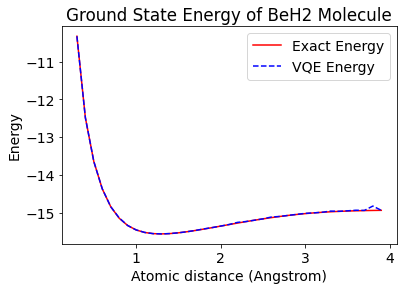

In [222]:

plt.plot(distances, exact_energies, label="Exact Energy", color = 'red')
plt.plot(distances, vqe_energies, label="VQE Energy", color='blue', linestyle='dashed')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.title('Ground State Energy of BeH2 Molecule')
plt.legend()
plt.show()